# Categorical Model Dedicated Notebook

## Data Admin:

15795
15795
15795
15795
(15795, 120, 160, 3)
350


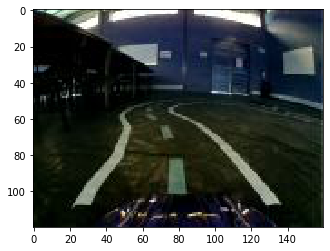

[1. 0. 0.]


In [52]:
import os
import natsort
import numpy as np
import cv2
import json
from random import randrange

import matplotlib.pyplot as plt

%matplotlib inline

#finding and sorting images and label data: - Unthresholded Images!
path = 'halldatarecords2/'

im_list = []

rec_list = []

for file in os.listdir(path):
    #image = tf.image.decode_jpeg(file)
    #image = tf.cast(file, tf.float32)
    if 'cam' in file:
        im_list.append(file)
    elif 'record' in file:
        rec_list.append(file)

        
print(len(im_list))
print(len(rec_list))

im_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
rec_list.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

#reading in array of images:
x_images = np.zeros((len(rec_list), 120, 160, 3), dtype = np.float32)
randomImage = 350# = randrange(len(x_images))
for i in range(len(im_list)):
    filename = im_list[i]
    x_images[i,:,:,:] = tf.cast(cv2.imread(path+filename), tf.float32)
    
#loop over labels and create a list of left/right/straight based on a degree threshold (one-hot encoding?)
json_data = {}
y_labels = np.zeros((len(rec_list),3), dtype=np.float32) #setup label array for one-hot encoded left, right and straight
for i in range(len(rec_list)):
    filename = rec_list[i]
    with open(path+filename) as fp:
        json_data = json.load(fp)
        orient = json_data['user/angle']
        orient = float(orient)
        if orient > 0.05:
            y_labels[i] = [0,0,1] #right
            
        elif orient < -0.05:
            y_labels[i] = [1,0,0] #left
            
        else:
            y_labels[i] = [0,1,0] #straight
            
print(len(x_images))
print(len(y_labels))
print(x_images.shape)
print(randomImage)
plt.imshow(x_images[randomImage].astype('uint8'))
plt.show()
print(y_labels[randomImage])

(15795, 3)
700
1700
2700
3700
4700
5700
6700
7700
8700
9700
10700
11700
12700
13700
14700
(11057, 120, 160, 3)
(4739, 120, 160, 3)
(11057, 3)
(4739, 3)
[0. 1. 0.]


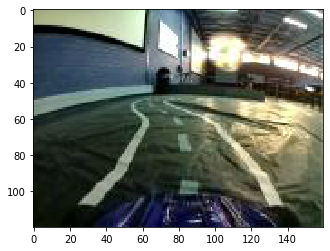

In [53]:
#training and validation split:

memv = 0
memt = 0
x_val = np.zeros((round(len(x_images)*0.3)+1,120,160,3), dtype=np.float32)
x_train = np.zeros((round(len(x_images)*0.7)+1,120,160,3), dtype=np.float32)
y_val = np.zeros((round(len(x_images)*0.3)+1,3), dtype=np.float32)
y_train = np.zeros((round(len(x_images)*0.7)+1,3), dtype=np.float32)
n=0
print(y_labels.shape)

for i in range(len(x_images)):
    if (i>=1000)and(i % 1000 == 0):
        j = i - 300
        k = i - 1000
        print(j)
        o = 0
        p = 0
        for l in range(0+n*300, n*300+300):
            x_val[l] = x_images[j+o,:,:,:]
            y_val[l] = y_labels[j+o]
            o +=1
        for m in range(0+n*700, n*700+700):
            x_train[m] = x_images[k+p,:,:,:]
            y_train[m] = y_labels[k+p]
            p+=1
        n+=1
        
print(x_train.shape)
print(x_val.shape)

print(y_train.shape)
print(y_val.shape)

print(y_val[randomImage])
plt.imshow(x_val[randomImage].astype('uint8'))
plt.show()
#obtaining test data

#relabeling test data

## Model Setup:

In [54]:
# Imports: Tensorflow 1.14.0 is used
import os
import numpy as np

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda

#Model Structure Setup: no dropout, no regularization yet

model = Sequential()
model.add(Convolution2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(120, 160, 3)))
model.add(Convolution2D(32, (3,3), strides=(2,2), activation='relu'))
model.add(Convolution2D(64, (3,3), strides=(2,2), activation='relu'))
model.add(Convolution2D(64, (3,3), strides=(1,1), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.summary()

# Compile model:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 58, 78, 24)        1824      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 38, 32)        6944      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 18, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 16, 64)        36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 11264)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               1126500   
_________________________________________________________________
dense_10 (Dense)             (None, 50)               

## Training and Validation:

In [55]:
model.fit(x_train, y_train, epochs=20, batch_size=200, validation_data=(x_val, y_val), shuffle=True, verbose=1)

Train on 11057 samples, validate on 4739 samples
Epoch 1/20
11057/11057 [==============================] - 33s 3ms/sample - loss: 1.7856 - accuracy: 0.7754 - val_loss: 0.5275 - val_accuracy: 0.7554
Epoch 2/20
11057/11057 [==============================] - 28s 3ms/sample - loss: 0.3034 - accuracy: 0.8387 - val_loss: 0.5359 - val_accuracy: 0.7451
Epoch 3/20
11057/11057 [==============================] - 28s 3ms/sample - loss: 3.3659 - accuracy: 0.8235 - val_loss: 10.2151 - val_accuracy: 0.7077
Epoch 4/20
11057/11057 [==============================] - 26s 2ms/sample - loss: 43.6993 - accuracy: 0.7341 - val_loss: 5.3078 - val_accuracy: 0.6463
Epoch 5/20
11057/11057 [==============================] - 26s 2ms/sample - loss: 188.5868 - accuracy: 0.7758 - val_loss: 7.5223 - val_accuracy: 0.7609
Epoch 6/20
11057/11057 [==============================] - 26s 2ms/sample - loss: 2467.3859 - accuracy: 0.7551 - val_loss: 3460.2897 - val_accuracy: 0.7250
Epoch 7/20
11057/11057 [=======================

right


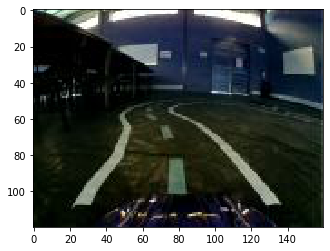

[0.11756378 0.09715757 0.7852786 ]


In [56]:
out = model.predict(x_images, batch_size=200)

if round(out[randomImage,0]) == 1:
    print('left')
elif round(out[randomImage, 1]) == 1:
    print('straight')
elif round(out[randomImage, 2]) == 1:
    print('right')
    
plt.imshow(x_images[randomImage].astype('uint8'))
plt.show()
print(out[randomImage])